# All In One Place

## 0.0. Requirements

### 0.1. Imports

In [2]:
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pandas_profiling import ProfileReport

from umap.umap_ import UMAP

from pyspark.sql import types
from pyspark.sql import SparkSession
from pyspark.sql import functions as pf

from pyspark.ml.stat import Correlation

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import UnivariateFeatureSelector, VarianceThresholdSelector

from pyspark.ml.feature import (
    RobustScaler,
    RobustScalerModel
)

from pyspark.ml.regression import (
    LinearRegression, 
    RandomForestRegressor,
    RandomForestRegressionModel
)

from pyspark.ml.clustering import (
    KMeans,
    KMeansModel,
    GaussianMixture,
    GaussianMixtureModel,
)

from pyspark.ml.evaluation import ClusteringEvaluator

from hyperopt import (
    SparkTrials,
    tpe,
    hp,
    fmin,
    STATUS_OK
) 

### 0.2. Aux Functions

In [160]:
def plot_simple_customer_statistics(df, customerid):
    df_max_gross = df.filter(pf.col("customerid") == customerid)

    df_max_gross.groupBy("customerid").agg(
        pf.min(pf.col("unitprice")).alias("min_product_price"), 
        pf.max(pf.col("unitprice")).alias("max_product_price"),
        pf.sum(pf.col("quantity")).alias("total_itens"),
        pf.count_distinct(pf.col("stockcode")).alias("unique_stockcodes"),
        pf.count_distinct(pf.col("invoiceno")).alias("unique_invoiceno"),
        pf.min(pf.col("invoicedate")).alias("first_purchase"),
        pf.max(pf.col("invoicedate")).alias("last_purchase")
    ).show()


def apply_robust_scaler(df, cols, save_scalers=True):

    for col in cols:
        
        vec = VectorAssembler(
            inputCols=[col],
            outputCol=f"vec_{col}"
        )

        df = vec.transform(df)

        robust_scaler = RobustScaler(
            inputCol=f"vec_{col}",
            outputCol=f"vec_{col}_scaled",
            withCentering=True,
            withScaling=True
        )

        model_scaler = robust_scaler.fit(df)

        if save_scalers:
            model_scaler.write().overwrite().save(f"../src/features/{col}_robust_scaler.spark")

        df = model_scaler.transform(df)

        df = df.drop(f"vec_{col}")

    return df

def apply_vectorizing(df, selected_features=["features", "customerid"]):
    df = df.select(selected_features[1:] + [k for k in df.columns if k.startswith("vec")])

    scaled_features = [k for k in df.columns if k.startswith("vec")]

    vec = VectorAssembler(
        inputCols=scaled_features,
        outputCol="features"
    )

    df_vector = vec.transform(df).select(selected_features)

    return df_vector

def plot_ellipsoids(gaussian_means, gaussian_covs):
    marker_kwargs = {
        "size": 5,
        "color": "blue",
        "opacity": 0.6
    }
    
    scene_kwargs = {
        "xaxis_title": "Feature 1",
        "yaxis_title": "Feature 2",
        "zaxis_title": "Feature 3"
    }
    
    scatter = go.Scatter3d(
        x=gaussian_means[:, 0],
        y=gaussian_means[:, 1],
        z=gaussian_means[:, 2],
        mode="markers",
        marker=marker_kwargs,
        name="Means"
    )
    
    ellipsoids = []
    
    for i, (mean, covariance) in enumerate(zip(gaussian_means, gaussian_covs)):
        eigenvalues, eigenvectors = np.linalg.eigh(covariance)
        std_devs = np.sqrt(eigenvalues)
    
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = mean[0] + std_devs[0] * np.outer(np.cos(u), np.sin(v))
        y = mean[1] + std_devs[1] * np.outer(np.sin(u), np.sin(v))
        z = mean[2] + std_devs[2] * np.outer(np.ones_like(u), np.cos(v))
    
        ellipsoid = go.Surface(
            x=x, y=y, z=z,
            opacity=0.3,
            showscale=False,
            name=f'Component {i+1}'
        )
        
        ellipsoids.append(ellipsoid)
    
    # Create Plot
    layout = go.Layout(scene=scene_kwargs)
    fig = go.Figure(data=[scatter] + ellipsoids, layout=layout)
    
    fig.update_layout(width=800, height=500)

    return fig

def plot_clusters_3d(plot_clusters):
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    cmap = plt.matplotlib.colors.ListedColormap(sns.color_palette("deep", 256).as_hex())

    sc = ax.scatter(
        plot_clusters[0], 
        plot_clusters[1],
        plot_clusters[2], 
        s=40, c=plot_clusters["cluster"], 
        marker='o', cmap=cmap, alpha=1
    )

    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2);

# Hyperopt
# Maybe i can add more params fox fix undefnided "df9"
def objective(params):
    k = int(params["k"])
    tol = float(params["tol"])
    aggregationDepth = int(params["aggregationDepth"])

    gmm = GaussianMixture(
        # Default Params
        featuresCol="features",
        probabilityCol="probability",
        maxIter=1000,

        # Tuning Params
        k=k,
        tol=tol,
        aggregationDepth=aggregationDepth
    )

    gmm = gmm.fit(df9)

    gmm.setPredictionCol("cluster")

    df_clusters = gmm.transform(df9)

    ev = ClusteringEvaluator(metricName="silhouette")
    ev.setPredictionCol("cluster")

    score = ev.evaluate(df_clusters)

    return {"loss": - score, "status": STATUS_OK}

### 0.3. Read Data

In [4]:
base_columns = [
    "InvoiceNo",
    "StockCode",
    "Description",
    "Quantity",
    "InvoiceDate",
    "UnitPrice",
    "CustomerID",
    "Country"
]

data_path = "/home/grc/arep/insiders_clustering/data/Ecommerce.csv"

In [ ]:
from pyspark import SparkContext

sc = SparkContext("local", "insiders")

In [5]:
spark = SparkSession.builder \
        .master("local[4]") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .appName("insiders") \
        .getOrCreate()

23/08/22 20:06:56 WARN Utils: Your hostname, grc resolves to a loopback address: 127.0.1.1; using 192.168.101.4 instead (on interface eno1)
23/08/22 20:06:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/22 20:06:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/22 20:06:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
df_raw = spark.read.format("csv").option("header", "true").option("inferSchema" , "true").load(data_path)

df_raw = df_raw.select(base_columns)

In [7]:
df_raw.show(5)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|  29-Nov-16|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|  29-Nov-16|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|  29-Nov-16|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|  29-Nov-16|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|  29-Nov-16|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 5 rows



## 1.0. Descriptive Statistics

### 1.1. Rename Columns

In [10]:
df1 = df_raw.select([pf.col(k).alias(k.lower().replace(" ", "_").strip()) for k in df_raw.columns])

### 1.2. Change Dtypes

In [11]:
df1.printSchema()

root
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- invoicedate: string (nullable = true)
 |-- unitprice: double (nullable = true)
 |-- customerid: integer (nullable = true)
 |-- country: string (nullable = true)



In [12]:
df1 = df1.withColumn(
    "invoicedate",
    pf.to_date(pf.unix_timestamp(pf.col("invoicedate"), "d-MMM-yy").cast("timestamp"))
)

### 1.3. Fill Missing Values

In [13]:
df1.select(
    [pf.count(pf.when(pf.isnull(pf.col(k)), 1)).alias(k) for k in df1.columns]
).show(2)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|invoiceno|stockcode|description|quantity|invoicedate|unitprice|customerid|country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [14]:
df1.filter(pf.isnull(pf.col("description"))).show(2)

+---------+---------+-----------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+-----------+--------+-----------+---------+----------+--------------+
|   536414|    22139|       null|      56| 2016-11-29|      0.0|      null|United Kingdom|
|   536545|    21134|       null|       1| 2016-11-29|      0.0|      null|United Kingdom|
+---------+---------+-----------+--------+-----------+---------+----------+--------------+
only showing top 2 rows



In [15]:
df1.filter(pf.isnull(pf.col("customerid"))).show(2)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536414|    22139|                null|      56| 2016-11-29|      0.0|      null|United Kingdom|
|   536544|    21773|DECORATIVE ROSE B...|       1| 2016-11-29|     2.51|      null|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 2 rows



In [16]:
# Remove Description and customer id null :(
df1 = df1.filter(
    pf.col("customerid").isNotNull() &
    pf.col("description").isNotNull()
)

### 1.4. Normalization Rows

In [17]:
for col in [k.name for k in df1.schema if k.dataType.typeName() in ['string']]:
    df1 = df1.withColumn(
        col,
        pf.regexp_replace(pf.lower(pf.trim(pf.col(col))), " ", "_")
    )

### 1.5. Descriptive Statistics

#### 1.5.1. Numeric Attributes

In [18]:
df_numeric = df1.select([k.name for k in df1.schema if k.dataType.typeName() in ['double', 'integer']])

In [19]:
df_c_distinct = df_numeric.select([pf.count_distinct(pf.col(k)).alias(k) for k in df_numeric.columns])
df_c_distinct = df_c_distinct.withColumn("summary", pf.lit("count_distinct"))
df_c_distinct = df_c_distinct.select(["summary"] + df_numeric.columns)

df_median = df_numeric.select([pf.median(pf.col(k)).alias(k) for k in  df_numeric.columns])
df_median = df_median.withColumn("summary", pf.lit("median"))
df_median = df_median.select(["summary"] + df_numeric.columns)

df_skewness = df_numeric.select([pf.skewness(pf.col(k)).alias(k) for k in df_numeric.columns])
df_skewness = df_skewness.withColumn("summary", pf.lit("skewness"))
df_skewness = df_skewness.select(["summary"] + df_numeric.columns)

df_kurtosis = df_numeric.select([pf.kurtosis(pf.col(k)).alias(k) for k in df_numeric.columns])
df_kurtosis = df_kurtosis.withColumn("summary", pf.lit("kurtosis"))
df_kurtosis = df_kurtosis.select(["summary"] + df_numeric.columns)

df_mode = df_numeric.select([pf.mode(pf.col(k)).alias(k) for k in df_numeric.columns])
df_mode = df_mode.withColumn("summary", pf.lit("mode"))
df_mode = df_mode.select(["summary"] + df_numeric.columns)

In [20]:
df_c_distinct.union(df_numeric.describe()).union(df_median).union(df_skewness).union(df_kurtosis).union(df_mode).show()

+--------------+-------------------+------------------+--------------------+
|       summary|           quantity|         unitprice|          customerid|
+--------------+-------------------+------------------+--------------------+
|count_distinct|                436|               620|                4372|
|         count|             406829|            406829|              406829|
|          mean|  12.06130339774205| 3.460471018537621|  15287.690570239585|
|        stddev| 248.69337001882548| 69.31516172321396|   1713.600303321593|
|           min|             -80995|               0.0|               12346|
|           max|              80995|           38970.0|               18287|
|        median|                5.0|              1.95|             15152.0|
|      skewness|0.18266199524826318|  452.217351341756|0.029834880048379368|
|      kurtosis|  94316.40448314806|246921.50823746304| -1.1799826182500506|
|          mode|                  1|              1.25|               17841|

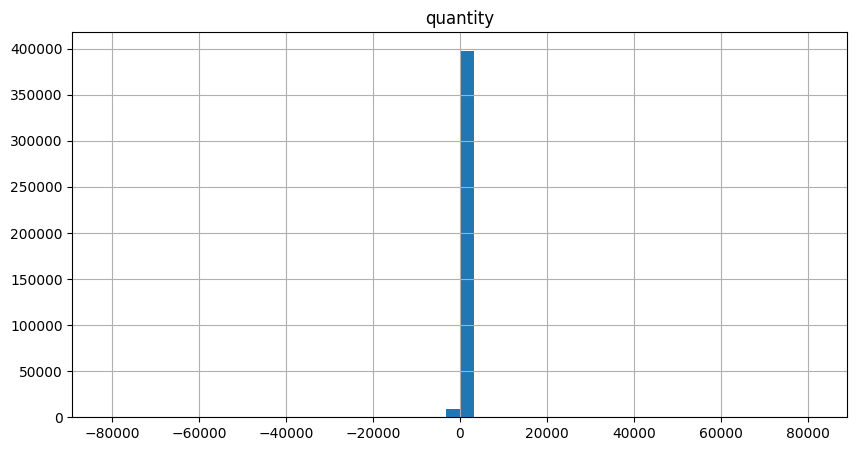

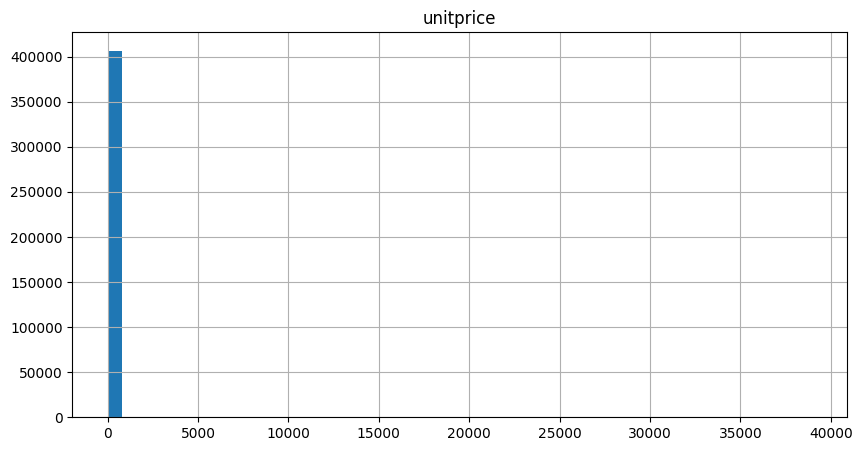

In [21]:
for k in ['quantity', 'unitprice']:
    df_numeric.select(k).toPandas().hist(figsize=(10,5), bins=50);

#### 1.5.2. Categorical Attributes

In [22]:
df_categorical = df1.select([k.name for k in df1.schema if k.dataType.typeName() in ['string']])

In [23]:
df_c_distinct = df_categorical.select([pf.count_distinct(pf.col(k)).alias(k) for k in df_categorical.columns])
df_c_distinct = df_c_distinct.withColumn("summary", pf.lit("count_distinct"))
df_c_distinct = df_c_distinct.select(["summary"] + df_categorical.columns)

df_c_distinct.union(df_categorical.describe()).show()

23/08/22 20:07:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+------------------+------------------+--------------------+---------+
|       summary|         invoiceno|         stockcode|         description|  country|
+--------------+------------------+------------------+--------------------+---------+
|count_distinct|             22190|              3684|                3885|       37|
|         count|            406829|            406829|              406829|   406829|
|          mean| 560617.1266447864|27430.341352504624|                null|     null|
|        stddev|13106.167694744545| 16403.57045262611|                null|     null|
|           min|            536365|             10002|"assorted_flower_...|australia|
|           max|           c581569|              post|zinc_wire_sweethe...|      usa|
+--------------+------------------+------------------+--------------------+---------+



##### 1.5.2.1. Stock Code

In [24]:
df_categorical.select(
    pf.regexp_replace(
        pf.regexp_replace(pf.col("stockcode"), "[0-9]+[a-z]", ""),
        "[0-9]+", ""
    ).alias("stockcode")
).distinct().show()

+------------+
|   stockcode|
+------------+
|           l|
|           m|
|bank_charges|
|           d|
|           c|
|            |
|        post|
|        pads|
|         dot|
|        cruk|
+------------+



In [25]:
df_filter = df_categorical.select(
    pf.regexp_replace(pf.col("stockcode"), "[0-9]+", "")
).distinct()

In [26]:
df_filter.filter(
    pf.col("stockcode").contains("l")
).distinct().show()

+--------------------------------------+
|regexp_replace(stockcode, [0-9]+, , 1)|
+--------------------------------------+
|                                    bl|
|                                     l|
+--------------------------------------+



In [27]:
filter_stock_codes = df_categorical.select(
    pf.regexp_replace(
        pf.regexp_replace(pf.col("stockcode"), "[0-9]+[a-z]", ""),
        "[0-9]+", ""
    ).alias("stockcode")
).distinct().collect()

filter_stock_codes = [k.asDict()["stockcode"] for k in filter_stock_codes]

##### 1.5.2.2. Invoice No

In [28]:
df_categorical.select(
    pf.regexp_replace(
        pf.regexp_replace(pf.col("invoiceno"), "[0-9]+[a-z]", ""),
        "[0-9]+", ""
    ).alias("invoiceno")
).distinct().show()

+---------+
|invoiceno|
+---------+
|        c|
|         |
+---------+



In [29]:
df1.filter(
    pf.col("invoiceno").contains("c")
).show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|  c536379|        d|            discount|      -1| 2016-11-29|     27.5|     14527|united_kingdom|
|  c536383|   35004c|set_of_3_coloured...|      -1| 2016-11-29|     4.65|     15311|united_kingdom|
|  c536391|    22556|plasters_in_tin_c...|     -12| 2016-11-29|     1.65|     17548|united_kingdom|
|  c536391|    21984|pack_of_12_pink_p...|     -24| 2016-11-29|     0.29|     17548|united_kingdom|
|  c536391|    21983|pack_of_12_blue_p...|     -24| 2016-11-29|     0.29|     17548|united_kingdom|
|  c536391|    21980|pack_of_12_red_re...|     -24| 2016-11-29|     0.29|     17548|united_kingdom|
|  c536391|    21484|chick_grey_hot_wa...|     -12| 2016-11-29|     3.45|     17548|united_kingdom|


In [30]:
df1.select(["invoiceno", "quantity"]).filter(
    pf.col("invoiceno").contains("c")
).distinct().show()

+---------+--------+
|invoiceno|quantity|
+---------+--------+
|  c538833|      -2|
|  c539644|      -1|
|  c540270|      -1|
|  c542366|      -2|
|  c542424|      -5|
|  c545436|      -1|
|  c538059|      -6|
|  c538350|      -4|
|  c539956|     -15|
|  c542348|      -1|
|  c542805|      -1|
|  c543757|      -1|
|  c544420|      -2|
|  c545769|     -18|
|  c546302|      -1|
|  c546901|      -2|
|  c548463|     -46|
|  c548972|      -4|
|  c537853|      -1|
|  c539289|      -3|
+---------+--------+
only showing top 20 rows



In [31]:
df1.filter(
    (pf.col("invoiceno").contains("c")) &
    (pf.col("quantity") >= 0)
).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|invoiceno|stockcode|description|quantity|invoicedate|unitprice|customerid|country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



##### 1.5.2.3. Country

In [32]:
df1.select("country").distinct().show(10)

+--------------+
|       country|
+--------------+
|       finland|
|     australia|
|        greece|
|      portugal|
|        israel|
|        poland|
|       austria|
|czech_republic|
|       lebanon|
|         japan|
+--------------+
only showing top 10 rows



In [33]:
df1.groupBy("country").count().orderBy("count").show()

+--------------------+-----+
|             country|count|
+--------------------+-----+
|        saudi_arabia|   10|
|             bahrain|   17|
|      czech_republic|   30|
|              brazil|   32|
|           lithuania|   35|
|             lebanon|   45|
|                 rsa|   58|
|  european_community|   61|
|united_arab_emirates|   68|
|               malta|  127|
|              greece|  146|
|              canada|  151|
|             iceland|  182|
|           singapore|  229|
|         unspecified|  244|
|              israel|  250|
|                 usa|  291|
|              poland|  341|
|               japan|  358|
|             denmark|  389|
+--------------------+-----+
only showing top 20 rows



## 2.0. Business Data Filtering

### 2.1. Filtering Rows and Columns

In [34]:
filter_stock_codes

['l', 'm', 'bank_charges', 'd', 'c', '', 'post', 'pads', 'dot', 'cruk']

In [35]:
df2 = df1.select(
    "invoiceno",
    "stockcode",
    "quantity",
    "invoicedate",
    "unitprice",
    "customerid",
    "country"
).filter(
    (pf.col("unitprice") > 0.04) &
    (~pf.col("stockcode").isin(filter_stock_codes)) &
    (~pf.col("country").isin(["european_community", "unspecified"])) & 
    (~pf.col("customerid").isin(
        [16446, 12346, 15749, 15098, 15749]
    ))
)

In [36]:
df2_returns = df2.filter(pf.col("quantity") < 0)
df2_purchases = df2.filter(pf.col("quantity") > 0)

## 3.0. Feature Engineering

In [37]:
df_ref = df2.select("customerid").distinct()

### 3.1. Gross Revenue

Unit price * quantity

In [38]:
df2_purchases = df2_purchases.withColumn(
    "gross_revenue",
    pf.round(pf.col("quantity") * pf.col("unitprice"), 3)
)

df_gross_revenue = df2_purchases.groupBy("customerid").agg(pf.sum(pf.col("gross_revenue")).alias("gross_revenue"))

df_ref = df_ref.join(df_gross_revenue, on="customerid", how="left")

### 3.2. Recency

Quantity of days util last purchase

In [39]:
df_recency = df2_purchases.groupBy("customerid").agg(pf.max(pf.col("invoicedate")).alias("last_purchase"))

df_recency = df_recency.withColumn(
    "max_invoicedate",
    pf.lit(df2_purchases.select(pf.max(pf.col("invoicedate"))).collect()[0][0])
)

df_recency = df_recency.withColumn(
    "recency_days",
    pf.datediff(pf.col("max_invoicedate"), pf.col("last_purchase"))
)

df_ref = df_ref.join(df_recency.select("customerid", "recency_days"), on="customerid", how="left")

### 3.3. Quantity of Stock Code Purchase

Quantity of stock codes (products) purchased.

In [40]:
df_qtd_products = df2_purchases.groupBy("customerid").agg(pf.count_distinct(pf.col("stockcode")).alias("qtde_products"))

df_ref = df_ref.join(df_qtd_products, on="customerid", how="left")

### 3.4. Sum of Item Quantity Purchase

In [41]:
df_qtd_items = df2_purchases.groupBy("customerid").agg(pf.sum(pf.col("quantity")).alias("qtde_total_items"))

df_ref = df_ref.join(df_qtd_items, on="customerid", how="left")

### 3.5. Gross Revenue By Quantity Products

how much gross revenue is generated for total unit of product quantity sold

In [42]:
df_ref = df_ref.withColumn(
    "gross_by_quantity",
    pf.col("gross_revenue") / pf.col("qtde_total_items")
)

### 3.6. Frequency

Quantity Products / Customer Lifetime interval days

In [43]:
df_distinct = df2_purchases.select("customerid", "invoicedate", "invoiceno").distinct()

df_distinct = df_distinct.groupBy("customerid").agg(
    pf.max(pf.col("invoicedate")).alias("_max"),
    pf.min(pf.col("invoicedate")).alias("_min"),
    pf.count(pf.col("invoiceno")).alias("_buy")
)

df_distinct = df_distinct.withColumn(
    "_diff",
    pf.datediff(pf.col("_max"), pf.col("_min")) + 1
)

df_distinct = df_distinct.withColumn(
    "frequency",
    pf.col("_buy") / pf.col("_diff")
).select(
    pf.col("customerid"),
    pf.col("frequency")
)

df_ref = df_ref.join(df_distinct, on="customerid", how="left")

### 3.7. Qtd Returns

In [44]:
df_returns = df2_returns.groupBy("customerid").agg(pf.sum("quantity").alias("qtde_returns"))

df_returns = df_returns.withColumn(
    "qtde_returns",
    pf.col("qtde_returns") * -1
)

df_ref = df_ref.join(df_returns, on="customerid", how="left")

### 3.8. Quantity of Invoices

In [45]:
df_invoices = df2_purchases.groupBy("customerid").agg(pf.count_distinct(pf.col("invoiceno")).alias("qtde_invoices"))

df_ref = df_ref.join(df_invoices, on="customerid", how="left")

### 3.9. Check Null Values

In [46]:
df_ref.show()

+----------+------------------+------------+-------------+----------------+------------------+--------------------+------------+-------------+
|customerid|     gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|           frequency|qtde_returns|qtde_invoices|
+----------+------------------+------------+-------------+----------------+------------------+--------------------+------------+-------------+
|     17420| 598.8299999999999|          50|           28|             265|2.2597358490566033|0.009259259259259259|        null|            3|
|     16861|            173.76|          59|            6|             140| 1.241142857142857|                0.02|           6|            2|
|     16503|1431.9299999999998|         106|           71|             569|2.5165729349736377| 0.01568627450980392|           2|            4|
|     15727| 5178.959999999998|          16|          213|            3065|1.6897096247960843|0.020348837209302327|        null|            7|

In [47]:
df_ref.select(
    [pf.count(pf.when(pf.isnull(pf.col(k)), 1)).alias(k) for k in df_ref.columns]
).show()

+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|customerid|gross_revenue|recency_days|qtde_products|qtde_total_items|gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|         0|           28|          28|           28|              28|               28|       28|        2825|           28|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+



In [48]:
# If returns is none, the customer never returned nothing
df_ref = df_ref.na.fill(value=0, subset=["qtde_returns"])

In [49]:
df_ref.filter(pf.isnull(pf.col("gross_revenue"))).show()

+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|customerid|gross_revenue|recency_days|qtde_products|qtde_total_items|gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|     12943|         null|        null|         null|            null|             null|     null|           1|         null|
|     16138|         null|        null|         null|            null|             null|     null|           1|         null|
|     13958|         null|        null|         null|            null|             null|     null|          23|         null|
|     17547|         null|        null|         null|            null|             null|     null|           4|         null|
|     15638|         null|        null|         null|            null|             null|     null|          52|       

In [50]:
df_ref = df_ref.filter((~pf.isnull(pf.col("gross_revenue"))))

In [51]:
df_ref.select(
    [pf.count(pf.when(pf.isnull(pf.col(k)), 1)).alias(k) for k in df_ref.columns]
).show()

+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|customerid|gross_revenue|recency_days|qtde_products|qtde_total_items|gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|         0|            0|           0|            0|               0|                0|        0|           0|            0|
+----------+-------------+------------+-------------+----------------+-----------------+---------+------------+-------------+



## 4.0. EDA Feature Behavior for Clustering

In [52]:
df4 = df_ref.select([pf.col(k) for k in df_ref.columns])

### 4.1. Univariate Analysis

In [53]:
df4.describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------+------------------+-----------------+
|summary|        customerid|     gross_revenue|      recency_days|    qtde_products|  qtde_total_items|  gross_by_quantity|           frequency|      qtde_returns|    qtde_invoices|
+-------+------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------+------------------+-----------------+
|  count|              4325|              4325|              4325|             4325|              4325|               4325|                4325|              4325|             4325|
|   mean|15300.929248554914|1949.9365156069393| 92.09387283236994|61.48184971098266|1149.8839306358382| 2.2349171280083304|  0.4042442400569476|21.850173410404626|4.250635838150289|
| stddev|1721.9331026971438| 8445.945448654618|100.16102194111322|85.35167201157616| 4761.

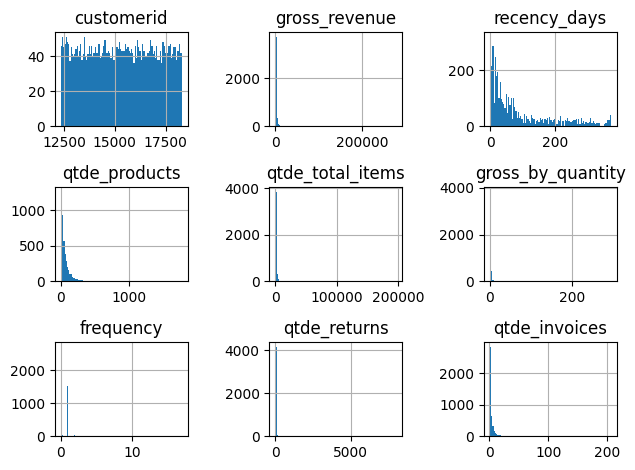

In [52]:
df4.toPandas().hist(bins=100);
plt.tight_layout()

In [53]:
#profile = ProfileReport(df4.toPandas())
#profile.to_file("output_v2.html")

#### 4.1.1. Gross Revenue

In [54]:
df_95_percent = df4.filter(pf.col("gross_revenue") > 5734.5635)

In [55]:
df_95_percent.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
|summary|        customerid|     gross_revenue|      recency_days|     qtde_products|  qtde_total_items| gross_by_quantity|           frequency|      qtde_returns|     qtde_invoices|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
|  count|               214|               214|               214|               214|               214|               214|                 214|               214|               214|
|   mean|14887.275700934579|19120.744158878515|18.200934579439252|207.22429906542055|10777.570093457944|2.0223739829661596| 0.10974740937469499|242.51869158878506| 22.72429906542056|
| stddev|1792.7062930691134| 33346.78311119376|31.195458304707934|237.76187671094794|

##### 4.1.1.1. Max Quantity Itens 

In [56]:
df_95_percent.filter(pf.col("qtde_total_items") == 196844).show()

+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|         frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|     14646|279138.0199999998|           1|          699|          196844|1.4180672004226687|0.2033898305084746|         288|           72|
+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+



##### 4.1.1.2. Recency Days Top Gross Revenue

In [ ]:
df_95_percent.select(pf.max(pf.col("qtde_total_items"))).show()

# On previous analisys on another notebook, theses clients now filter
df_95_percent.select("qtde_total_items").distinct().sort(pf.col("qtde_total_items").desc()).show(20)

##### 4.1.1.3. Recency Days Top 1 Gross Revenue

In [ ]:
df_95_percent.filter(pf.col("qtde_total_items") == 79963).show()

df1.filter(pf.col("customerid") == 16532).show(5)

+----------+------------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|customerid|     gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|         frequency|qtde_returns|qtde_invoices|
+----------+------------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|     14911|140438.72000000015|           1|         1785|           79963|1.7562962870327545|0.5335120643431636|        3332|          199|
+----------+------------------+------------+-------------+----------------+------------------+------------------+------------+-------------+



In [ ]:
plot_simple_customer_statistics(df2, 14911)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     14911|             0.06|            165.0|      76631|             1791|             243|    2016-11-29|   2017-12-06|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



##### 4.1.1.4. Recency Days Top 2 Gross Revenue

In [ ]:
df_95_percent.filter(pf.col("qtde_total_items") == 77373).show()

df1.filter(pf.col("customerid") == 12415).show(5)

+----------+-------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+
|customerid|gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|          frequency|qtde_returns|qtde_invoices|
+----------+-------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+
|     12415|    124564.53|          24|          443|           77373|1.6099224535690744|0.06369426751592357|         427|           20|
+----------+-------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+

+---------+---------+--------------------+--------+-----------+---------+----------+---------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|  country|
+---------+---------+--------------------+--------+-----------+---------+----------+---------+
|   540267|    22078|ribbon_r

In [ ]:
plot_simple_customer_statistics(df2, 12415)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     12415|             0.19|            14.95|      76946|              443|              24|    2017-01-04|   2017-11-13|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



##### 4.1.1.5. Recency Days Top 3 Gross Revenue

In [ ]:
df_95_percent.filter(pf.col("qtde_total_items") == 69993).show()

df1.filter(pf.col("customerid") == 17450).show(5)

+----------+-----------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|          frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+
|     17450|194550.7899999999|           8|          124|           69993|2.7795749574957482|0.12777777777777777|         952|           46|
+----------+-----------------+------------+-------------+----------------+------------------+-------------------+------------+-------------+

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+----------

In [ ]:
plot_simple_customer_statistics(df2, 17450)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     17450|             0.72|            12.98|      69041|              124|              49|    2016-12-05|   2017-11-29|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



##### 4.1.1.6. Max Frequency 

In [ ]:
df_95_percent.filter(pf.col("frequency") >= 3.).show()

+----------+-----------------+------------+-------------+----------------+------------------+---------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+------------------+---------+------------+-------------+
|     16000|          12393.7|           2|            9|            5110|2.4253816046966734|      3.0|           0|            3|
|     18139|8438.339999999997|          17|           35|            5557|1.5185063883390313|      3.0|           0|            6|
+----------+-----------------+------------+-------------+----------------+------------------+---------+------------+-------------+



In [ ]:
df1.filter(pf.col("customerid") == 16000).show(10)

df1.filter(pf.col("customerid") == 18139).show(50)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   581105|    85152|hand_over_the_cho...|     620| 2017-12-05|     1.92|     16000|united_kingdom|
|   581105|    22457|natural_slate_hea...|     620| 2017-12-05|     2.55|     16000|united_kingdom|
|   581105|    22727|alarm_clock_bakel...|     620| 2017-12-05|     2.99|     16000|united_kingdom|
|   581105|    23497|classic_chrome_bi...|     620| 2017-12-05|     1.38|     16000|united_kingdom|
|   581105|    23498|classic_bicycle_c...|     620| 2017-12-05|     1.38|     16000|united_kingdom|
|   581105|    22961|jam_making_set_pr...|     620| 2017-12-05|     1.38|     16000|united_kingdom|
|   581105|    23552|bicycle_puncture_...|     620| 2017-12-05|     1.86|     16000|united_kingdom|


In [ ]:
plot_simple_customer_statistics(df2, 16000)

plot_simple_customer_statistics(df2, 18139)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     16000|             1.38|            13.35|       5110|                9|               3|    2017-12-05|   2017-12-05|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+

##### 4.1.1.7. Max & Min Invoices

In [ ]:
df_95_percent.filter(pf.col("qtde_invoices") == 1).show()

df_95_percent.filter(pf.col("qtde_invoices") >= 200).show()

+----------+-----------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items|gross_by_quantity|frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+-----------------+---------+------------+-------------+
|     12590|9341.260000000004|         211|           67|            4282|2.181517982251285|      1.0|           4|            1|
|     12357|6207.669999999996|          33|          131|            2708|2.292344903988182|      1.0|           0|            1|
+----------+-----------------+------------+-------------+----------------+-----------------+---------+------------+-------------+



+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|customerid|    gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|         frequency|qtde_returns|qtde_invoices|
+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+
|     12748|32305.31999999994|           0|         1765|           25211|1.2813978025465051|0.5508021390374331|        1535|          206|
+----------+-----------------+------------+-------------+----------------+------------------+------------------+------------+-------------+



In [ ]:
df1.filter(pf.col("customerid") == 12590).show()

+---------+---------+--------------------+--------+-----------+---------+----------+-------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|country|
+---------+---------+--------------------+--------+-----------+---------+----------+-------+
|   552978|   85014b|red_retrospot_umb...|      48| 2017-05-10|     4.95|     12590|germany|
|   552978|   85014a|black/blue_polkad...|      48| 2017-05-10|     4.95|     12590|germany|
|   552978|    22354|retrospot_padded_...|      60| 2017-05-10|     3.39|     12590|germany|
|   552978|    22558|clothes_pegs_retr...|      96| 2017-05-10|     1.25|     12590|germany|
|   552978|    22329|round_container_s...|      48| 2017-05-10|     1.45|     12590|germany|
|   552978|    22352|lunch_box_with_cu...|      60| 2017-05-10|      2.1|     12590|germany|
|   552978|    22195|large_heart_measu...|      24| 2017-05-10|     1.65|     12590|germany|
|   552978|    21035|set/2_red_retrosp...|     100| 2017-05-10|     2.

In [ ]:
plot_simple_customer_statistics(df2, 12590)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     12590|             0.65|             7.65|       4278|               67|               2|    2017-05-10|   2017-05-31|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



##### 4.1.1.8. Max Qtde Returns

In [ ]:
df_95_percent.sort(pf.col("qtde_returns").desc()).show()

+----------+------------------+------------+-------------+----------------+------------------+--------------------+------------+-------------+
|customerid|     gross_revenue|recency_days|qtde_products|qtde_total_items| gross_by_quantity|           frequency|qtde_returns|qtde_invoices|
+----------+------------------+------------+-------------+----------------+------------------+--------------------+------------+-------------+
|     16029|          72882.09|          38|           43|           40207|1.8126716740866018| 0.18452380952380953|        8004|           62|
|     12931| 42055.96000000001|          21|           28|           28004|1.5017840308527355| 0.04451038575667656|        4427|           15|
|     14607|           15021.5|          15|           37|           10734|1.3994317123160052|0.048582995951417005|        3768|           12|
|     14911|140438.72000000015|           1|         1785|           79963|1.7562962870327545|  0.5335120643431636|        3332|          199|

In [ ]:
df1.filter(
    (pf.col("customerid") == 16029) & 
    (pf.col("quantity") < 0)
).sort(pf.col("quantity").asc()).show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|  c570556|    20971|pink_blue_felt_cr...|   -1296| 2017-10-09|     1.06|     16029|united_kingdom|
|  c570556|    20971|pink_blue_felt_cr...|   -1296| 2017-10-09|     1.06|     16029|united_kingdom|
|  c570556|    22147|feltcraft_butterf...|    -840| 2017-10-09|     1.25|     16029|united_kingdom|
|  c570556|    22273|feltcraft_doll_molly|    -720| 2017-10-09|      2.3|     16029|united_kingdom|
|  c570556|    22273|feltcraft_doll_molly|    -720| 2017-10-09|     2.55|     16029|united_kingdom|
|  c570556|    22149|feltcraft_6_flowe...|    -600| 2017-10-09|     1.85|     16029|united_kingdom|
|  c570552|   85099b|jumbo_bag_red_ret...|    -300| 2017-10-09|     1.74|     16029|united_kingdom|


In [ ]:
plot_simple_customer_statistics(df2, 16029)

+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|customerid|min_product_price|max_product_price|total_itens|unique_stockcodes|unique_invoiceno|first_purchase|last_purchase|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+
|     16029|             0.94|             8.49|      32203|               43|              66|    2016-11-29|   2017-10-30|
+----------+-----------------+-----------------+-----------+-----------------+----------------+--------------+-------------+



In [ ]:
df1.filter(
    (pf.col("customerid") == 17949) & 
    (pf.col("quantity") < 0)
).sort(pf.col("quantity").asc()).show()

plot_simple_customer_statistics(df2, 17949)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|  c563577|    21877| home_sweet_home_mug|    -828| 2017-08-15|     1.06|     17949|united_kingdom|
|  c563577|    21069|vintage_billboard...|    -701| 2017-08-15|     1.06|     17949|united_kingdom|
|  c558553|    23170|regency_tea_plate...|    -576| 2017-06-28|     1.45|     17949|united_kingdom|
|  c563577|    21871| save_the_planet_mug|    -576| 2017-08-15|     1.06|     17949|united_kingdom|
|  c564081|    22423|regency_cakestand...|    -150| 2017-08-20|    10.95|     17949|united_kingdom|
|  c554127|        m|              manual|     -96| 2017-05-21|      5.0|     17949|united_kingdom|
|  c580171|    23108|set_of_10_led_dol...|     -24| 2017-11-30|     3.39|     17949|united_kingdom|


### 4.2. Multivariate Analysis

In [ ]:
vec = VectorAssembler(
    inputCols=df4.columns[1:],
    outputCol="Cors"
)

df_vector = vec.transform(df4.select(df4.columns[1:])).select("Cors")

matrix = Correlation.corr(df_vector, "Cors").collect()[0][0]

df_matrix = pd.DataFrame(matrix.toArray())

df_matrix.columns = df4.columns[1:]
df_matrix.index = df4.columns[1:]

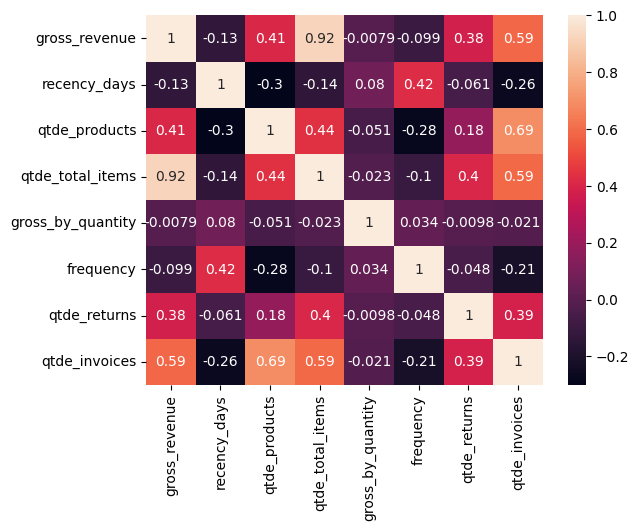

In [ ]:
sns.heatmap(
    df_matrix,
    annot=True
);

/home/grc/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


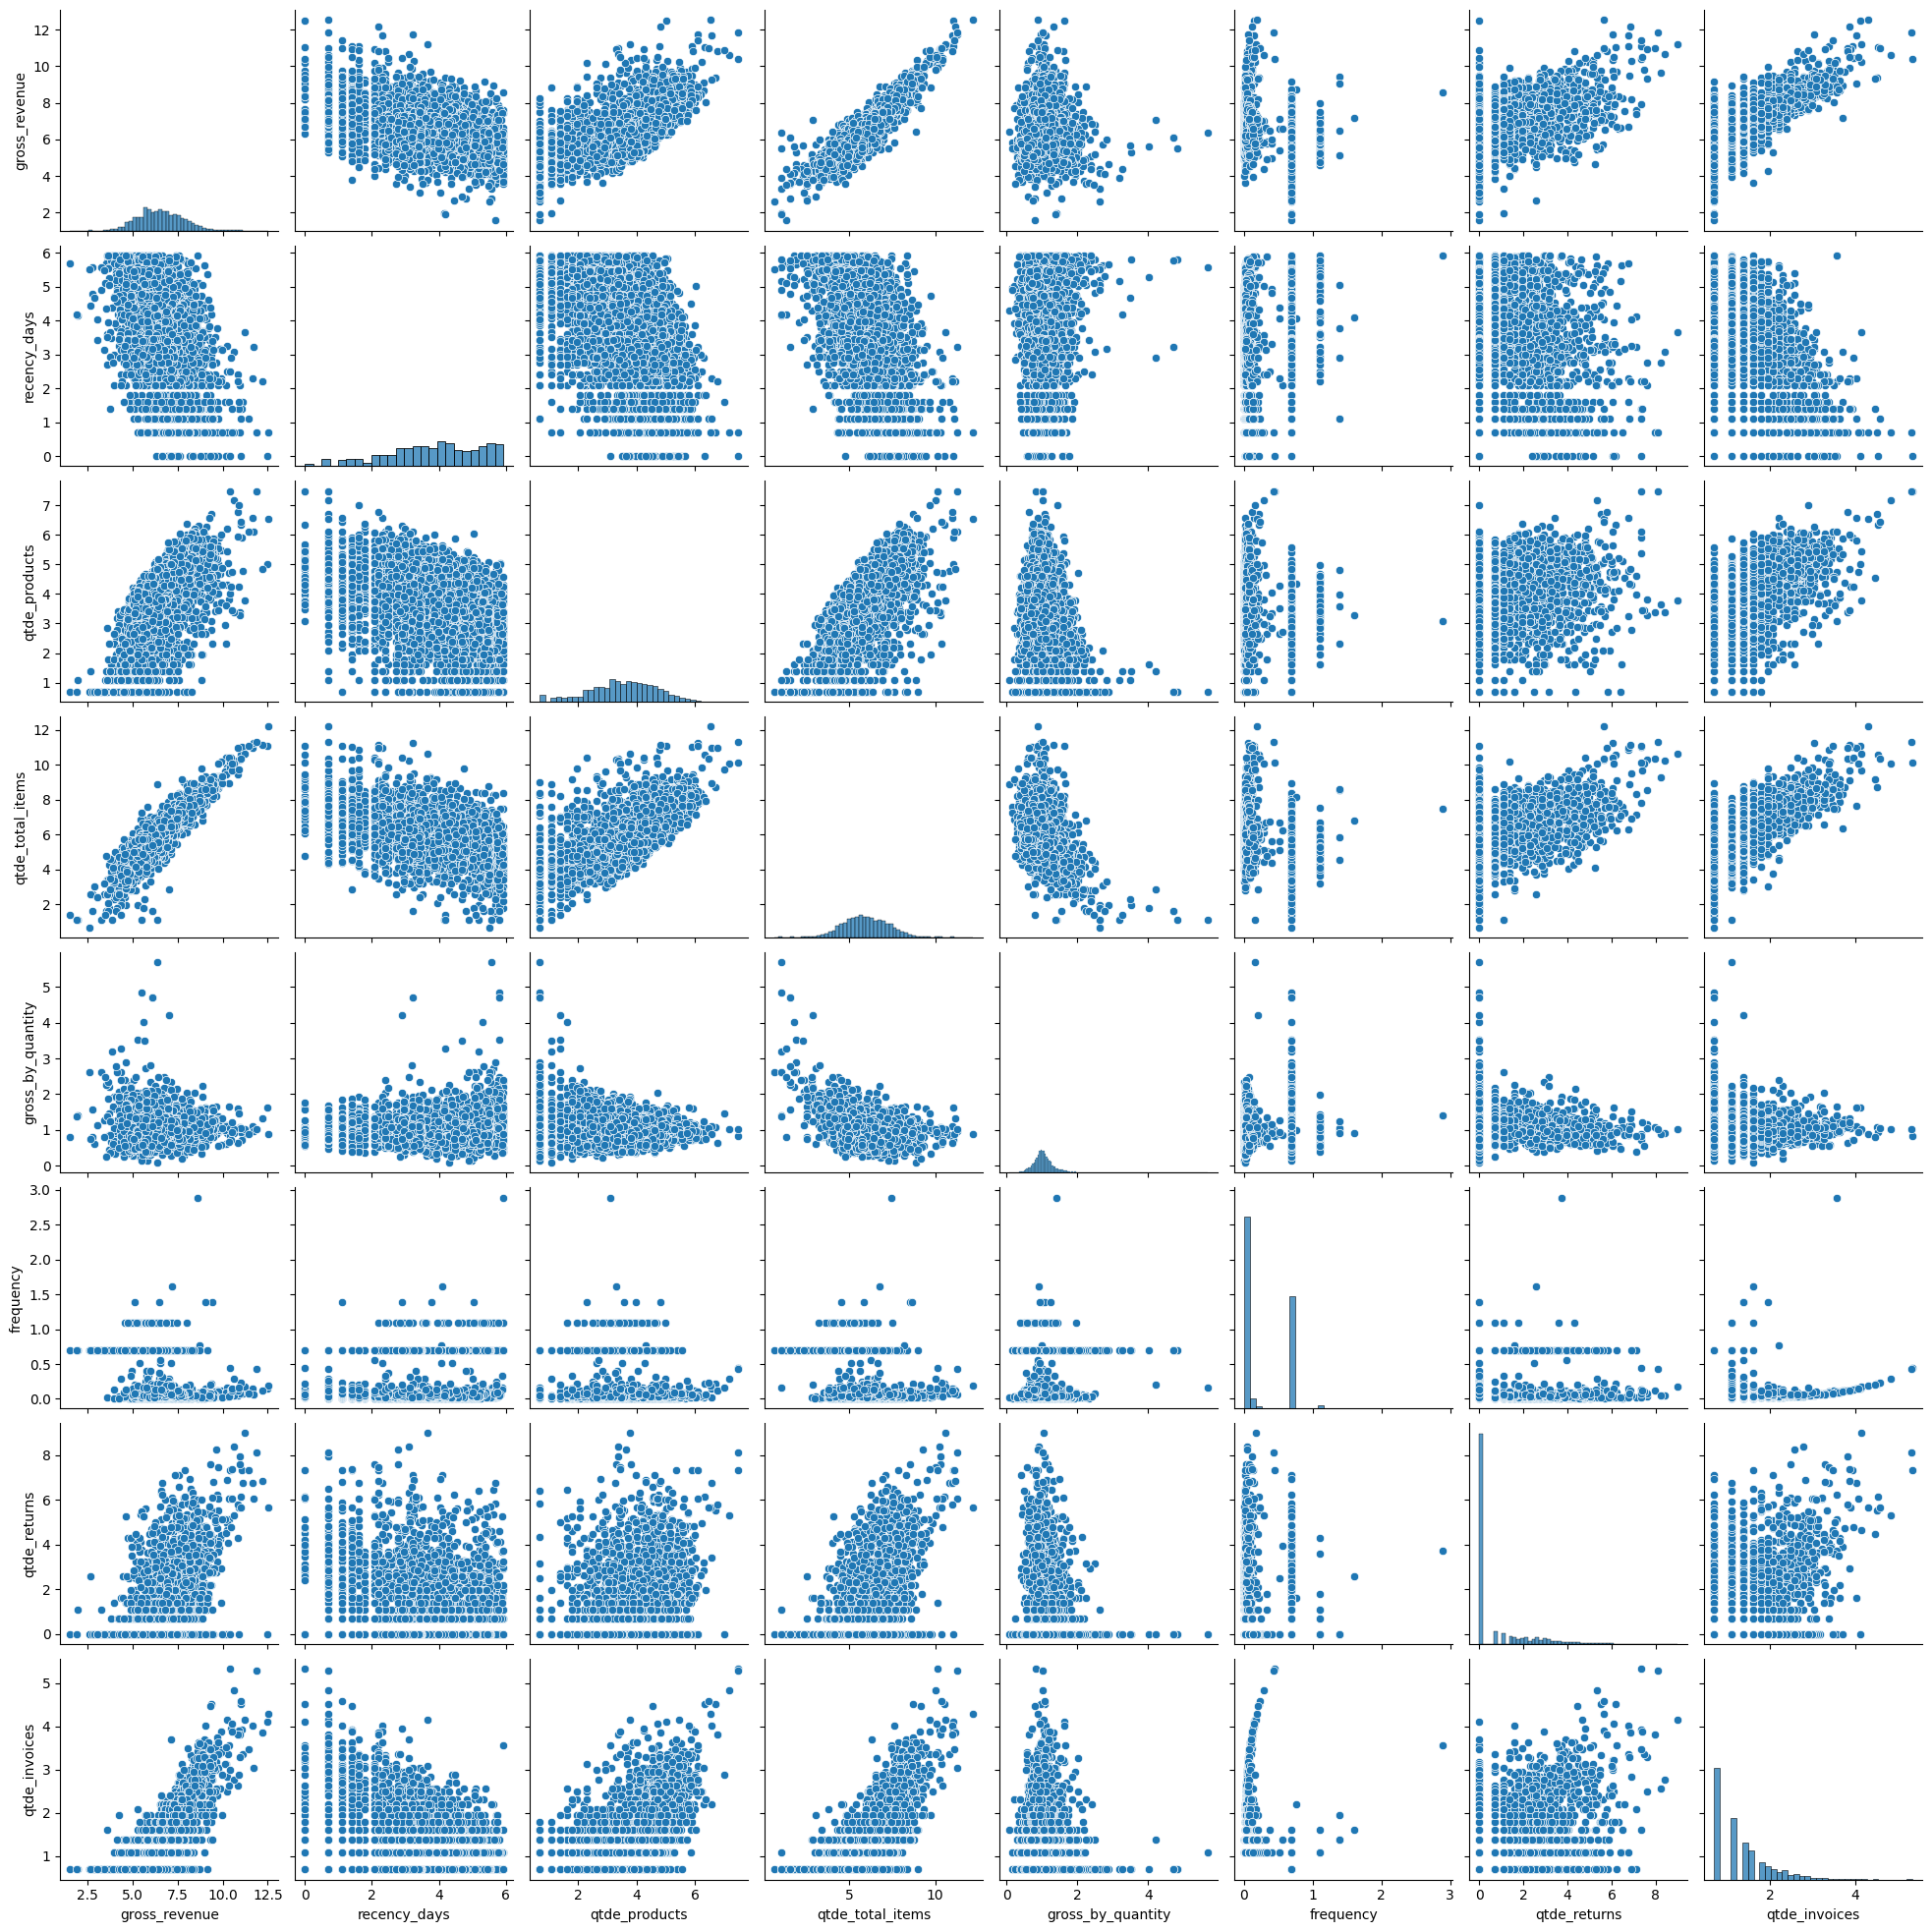

In [ ]:
sns.pairplot(np.log1p(df4.select(df4.columns[1:]).toPandas()));

/home/grc/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


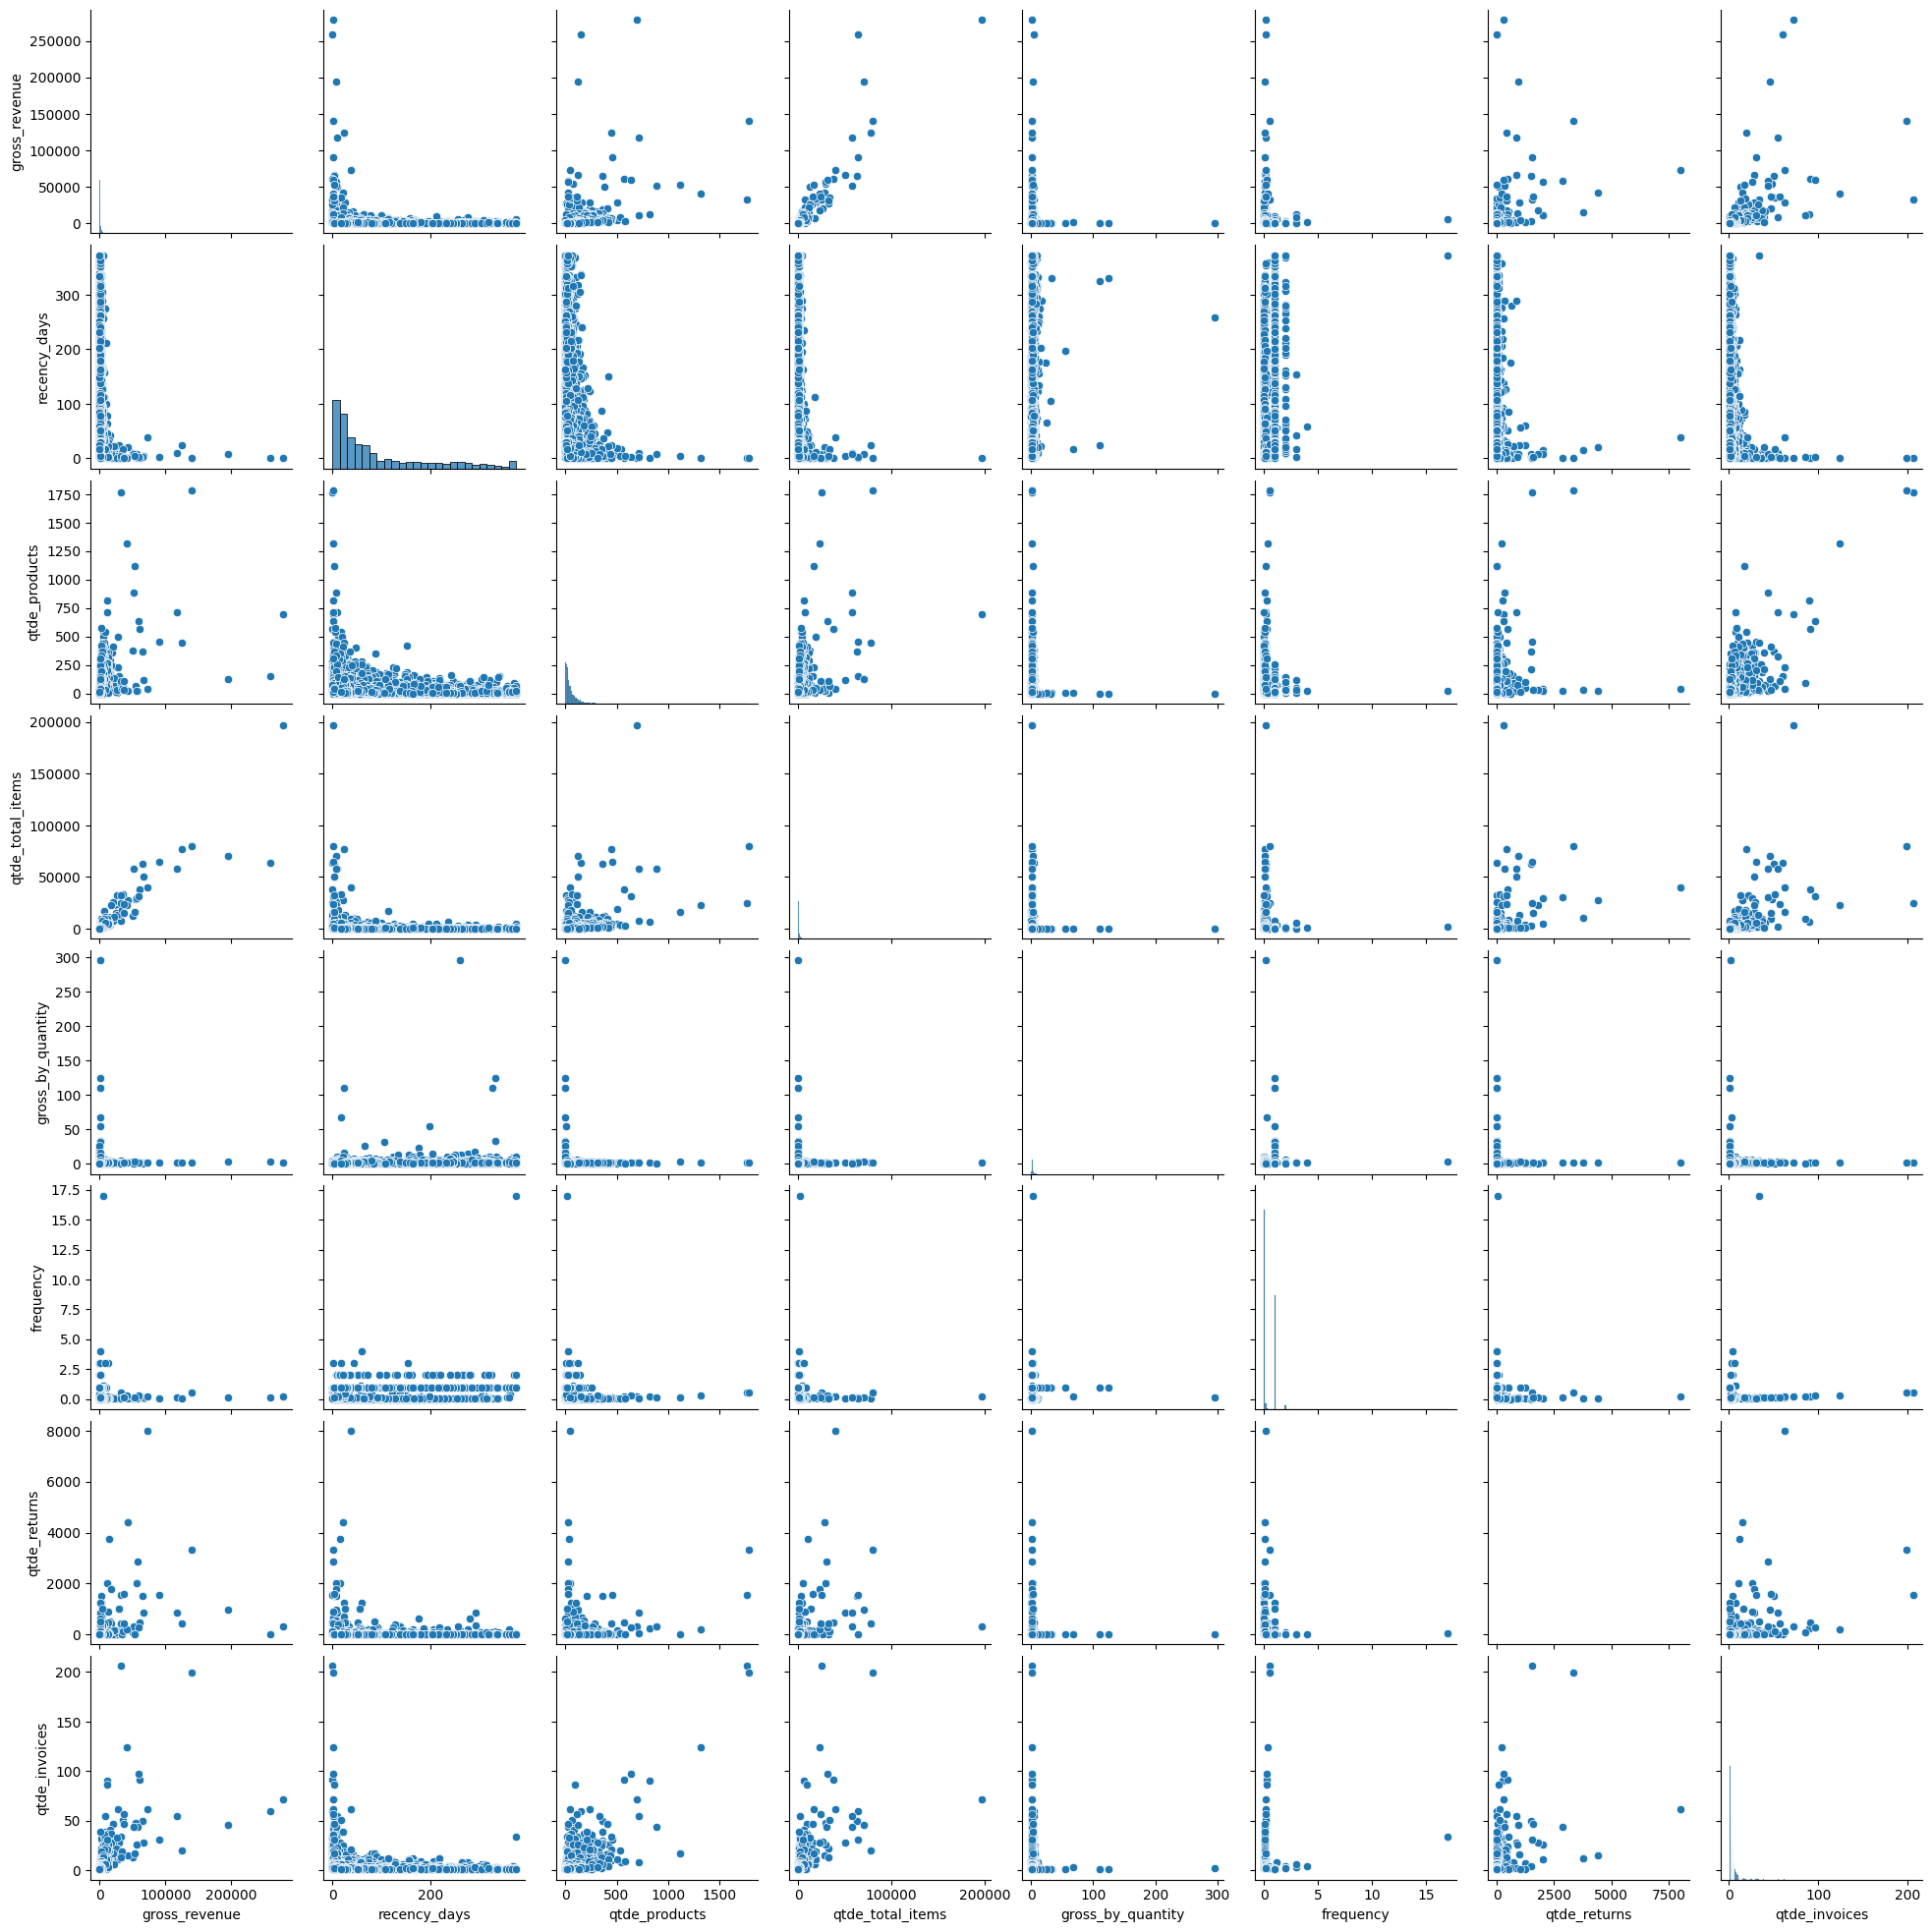

In [ ]:
sns.pairplot(df4.select(df4.columns[1:]).toPandas());

## 5.0. Data Preparation

In [54]:
df5 = df4.select([pf.col(k) for k in df4.columns])

cols = df5.columns[:]
df51 = df5.select(cols)

### 5.1. Reescaling

In [55]:
for col in cols:
    if col == "gross_revenue" or col == "customerid":
        continue

    vec = VectorAssembler(
        inputCols=[col],
        outputCol=f"vec_{col}"
    )

    df51 = vec.transform(df51)

    robust_scaler = RobustScaler(
        inputCol=f"vec_{col}",
        outputCol=f"vec_{col}_scaled",
        withCentering=True,
        withScaling=True
    )

    model_scaler = robust_scaler.fit(df51)

    model_scaler.write().overwrite().save(f"../src/features/{col}_robust_scaler.spark")

    df51 = model_scaler.transform(df51)

    df51 = df51.drop(f"vec_{col}")

### 5.2. Vectorize Columns to ML

In [56]:
df51.printSchema()

root
 |-- customerid: integer (nullable = true)
 |-- gross_revenue: double (nullable = true)
 |-- recency_days: integer (nullable = true)
 |-- qtde_products: long (nullable = true)
 |-- qtde_total_items: long (nullable = true)
 |-- gross_by_quantity: double (nullable = true)
 |-- frequency: double (nullable = true)
 |-- qtde_returns: long (nullable = true)
 |-- qtde_invoices: long (nullable = true)
 |-- vec_recency_days_scaled: vector (nullable = true)
 |-- vec_qtde_products_scaled: vector (nullable = true)
 |-- vec_qtde_total_items_scaled: vector (nullable = true)
 |-- vec_gross_by_quantity_scaled: vector (nullable = true)
 |-- vec_frequency_scaled: vector (nullable = true)
 |-- vec_qtde_returns_scaled: vector (nullable = true)
 |-- vec_qtde_invoices_scaled: vector (nullable = true)



In [57]:
df51 = df51.select(["customerid", "gross_revenue"] + [k for k in df51.columns if k.startswith("vec")])

In [58]:
scaled_features = df51.columns[2:]

scaled_features

['vec_recency_days_scaled',
 'vec_qtde_products_scaled',
 'vec_qtde_total_items_scaled',
 'vec_gross_by_quantity_scaled',
 'vec_frequency_scaled',
 'vec_qtde_returns_scaled',
 'vec_qtde_invoices_scaled']

In [59]:
vec = VectorAssembler(
    inputCols=scaled_features,
    outputCol="features"
)

df51_vector = vec.transform(df51).select("features", "gross_revenue", "customerid")

In [60]:
df51_vector.show(2)

+--------------------+------------------+----------+
|            features|     gross_revenue|customerid|
+--------------------+------------------+----------+
|[0.0,-0.114754098...| 598.8299999999999|     17420|
|[0.45161290322580...|1431.9299999999998|     16503|
+--------------------+------------------+----------+
only showing top 2 rows



## 6.0. Feature Selection

In [61]:
df6 = df51_vector.select(df51_vector.columns)

Anova Test, Variance Threshold, Lasso Coefs and Feature Importance

### 6.1. Statistics Tests

In [62]:
selector = UnivariateFeatureSelector(
    labelCol="gross_revenue",
    outputCol="selected_features"
)

selector.setFeatureType("continuous") \
        .setLabelType("continuous") \
        .setFeaturesCol("features") \
        .setSelectionMode("numTopFeatures") \
        .setSelectionThreshold(5)

model = selector.fit(df6.select("features", "gross_revenue"))

[f"Rank: {rank + 1}, {scaled_features[index]}" for rank, index in enumerate(model.selectedFeatures)]

['Rank: 1, vec_recency_days_scaled',
 'Rank: 2, vec_qtde_products_scaled',
 'Rank: 3, vec_qtde_total_items_scaled',
 'Rank: 4, vec_qtde_returns_scaled',
 'Rank: 5, vec_qtde_invoices_scaled']

### 6.2. Variance Threshold

In [364]:
selector = VarianceThresholdSelector(
    varianceThreshold=2.0,
    outputCol="selected_features"
)

model = selector.fit(df6.select("features"))

model.setFeaturesCol(model.getFeaturesCol())

[f"Rank: {rank + 1}, {scaled_features[index]}" for rank, index in enumerate(model.selectedFeatures)]

['Rank: 1, vec_qtde_total_items_scaled',
 'Rank: 2, vec_gross_by_quantity_scaled',
 'Rank: 3, vec_qtde_returns_scaled',
 'Rank: 4, vec_qtde_invoices_scaled']

### 6.3. Lasso Coefs

In [365]:
lr = LinearRegression(
    featuresCol="features",
    labelCol="gross_revenue",
    standardization=False,
    elasticNetParam=1,
    regParam=0.1
)

lr = lr.fit(df6.select("features", "gross_revenue"))

summary = lr.summary

In [366]:
pd.DataFrame(
    {"R2ADJ": summary.r2adj, 
     "RMSE": np.sqrt(summary.meanSquaredError),
     "Explained Variance": summary.explainedVariance
    },
    index=[0]
)

,R2ADJ,RMSE,Explained Variance
0,0.855282,3210.016901,6.101289e+07


In [367]:
[f"{scaled_features[i]}: {coef}" for i, coef in enumerate(lr.coefficients.toArray())]

['vec_recency_days_scaled: -14.374681947578894',
 'vec_qtde_products_scaled: -252.9536349387389',
 'vec_qtde_total_items_scaled: 1303.4324979870316',
 'vec_gross_by_quantity_scaled: 16.591620023667904',
 'vec_frequency_scaled: 29.425479327949645',
 'vec_qtde_returns_scaled: -0.767934813518991',
 'vec_qtde_invoices_scaled: 390.150534074366']

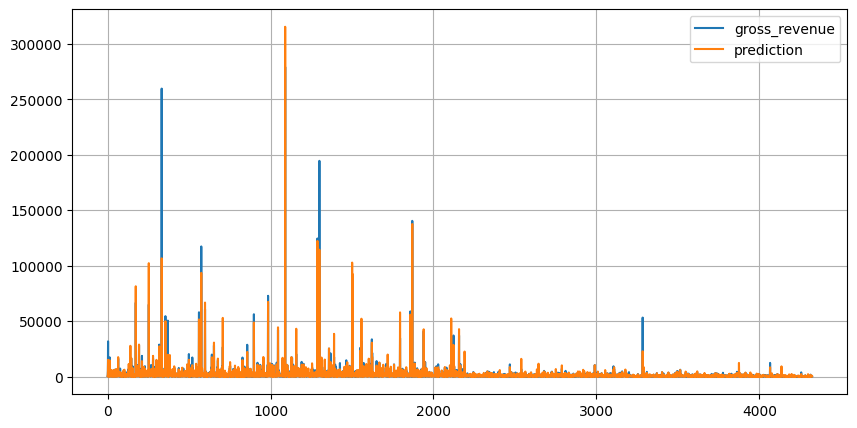

In [368]:
preds = summary.predictions.select("gross_revenue", "prediction")
preds.toPandas().plot(figsize=(10,5), grid=2);

### 6.4. Selected Features

In [63]:
selected_features = [
    "customerid",
    "gross_revenue",
    "recency_days",
    "qtde_total_items",
    "qtde_returns",
    "qtde_invoices"
]

df6 = df4.select(selected_features)

#### 6.4.1. Rescaling Selected Features

In [64]:
df6.columns[2:]

['recency_days', 'qtde_total_items', 'qtde_returns', 'qtde_invoices']

In [65]:
df6_tree = apply_robust_scaler(df6, df6.columns[2:], save_scalers=False)

df6_tree = apply_vectorizing(df6_tree, ["features", "customerid", "gross_revenue"])

df6_tree.show(2)

+--------------------+----------+------------------+
|            features|customerid|     gross_revenue|
+--------------------+----------+------------------+
|[0.0,-0.137135922...|     17420| 598.8299999999999|
|[0.45161290322580...|     16503|1431.9299999999998|
+--------------------+----------+------------------+
only showing top 2 rows



In [66]:
df6_cluster = apply_robust_scaler(df6, df6.columns[1:])

df6_cluster = apply_vectorizing(df6_cluster)

df6_cluster.show(2, truncate=False)

+-----------------------------------------------------------------------------------+----------+
|features                                                                           |customerid|
+-----------------------------------------------------------------------------------+----------+
|[-0.05092547030546204,0.0,-0.13713592233009708,0.0,0.25]                           |17420     |
|[0.5797569930731667,0.45161290322580644,0.23179611650485435,0.6666666666666666,0.5]|16503     |
+-----------------------------------------------------------------------------------+----------+
only showing top 2 rows



## 7.0. Feature Space Study

In [67]:
df7 = df6_tree.select(df6_tree.columns)

In [68]:
df7.show(2)

+--------------------+----------+------------------+
|            features|customerid|     gross_revenue|
+--------------------+----------+------------------+
|[0.0,-0.137135922...|     17420| 598.8299999999999|
|[0.45161290322580...|     16503|1431.9299999999998|
+--------------------+----------+------------------+
only showing top 2 rows



### 7.1. Random Forest Space

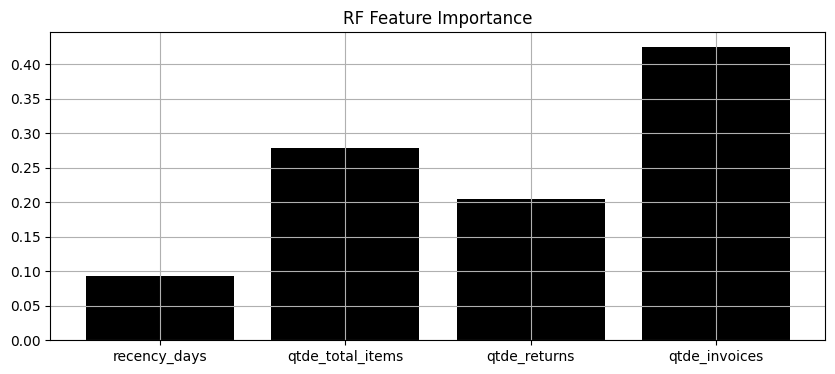

In [69]:
# Fit Forest
#rf = RandomForestRegressor(
#    featuresCol="features",
#    labelCol="gross_revenue",
#    maxDepth=5,
#    numTrees=100
#)
#
#rf = rf.fit(df7.select("features", "gross_revenue", "customerid"))
#
#rf.write().overwrite().save("../src/features/random_forest_model.spark")

rf2 = RandomForestRegressionModel.load("../src/features/random_forest_model.spark")

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(x=selected_features[2:], height=[k for k in rf2.featureImportances], color='k')
ax.set_title("RF Feature Importance")
ax.grid(2)

In [70]:
# Get Tree Indices
df_leaf = rf2.transform(
    df7.select("features", "gross_revenue", "customerid"), 
    {rf2.leafCol: "leaf_indices"}
)

In [71]:
df_leaf.select("customerid", "leaf_indices").show(2, truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customerid|leaf_indices                                                                                                                                                                                                                                                                                                                                                                                                     |
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------

Do not exists umap in pyspark, i need to use pandas and external package

In [72]:
# Convert Leaf vector in Pandas dataframe
df_leaf_pandas = pd.DataFrame([np.array(k[0]) for k in df_leaf.select("leaf_indices").collect()])

# Get customerid
df_leaf_customer_pandas = df_leaf.select("customerid").toPandas()

# Concat Values
df_leaf_pandas = pd.concat([df_leaf_pandas, df_leaf_customer_pandas], axis=1)

In [73]:
df_leaf_pandas.head(2)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,customerid
0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,5.0,1.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0,17420
1,1.0,6.0,2.0,1.0,1.0,2.0,5.0,3.0,1.0,2.0,...,6.0,2.0,2.0,4.0,4.0,2.0,2.0,2.0,1.0,16503


### 7.2. Fit Umap Reducer

In [74]:
umap_params = dict(
    n_neighbors=30,
    metric="correlation",
    learning_rate=1.0,
    init="spectral",
    n_epochs=500,
    min_dist=0.1,
    transform_mode="embedding",
    random_state=123 # Random State for Repro
)

In [75]:
n = 3

#reducer = UMAP(**umap_params)
#reducer.set_params(n_components=n)
#embs = reducer.fit_transform(df_leaf_pandas.iloc[:, :-1])
#
# Save Model
#pickle.dump(reducer, open("../src/features/umap_reducer.pickle", "wb"))
#
#embs = pd.DataFrame(embs)

reducer = pickle.load(open("../src/features/umap_reducer.pickle", "rb"))

embs = reducer.transform(df_leaf_pandas.iloc[:, :-1])
embs = pd.DataFrame(embs)

embs_with_customer = pd.concat([embs, df_leaf_pandas[["customerid"]]], axis=1)

In [76]:
embs_with_customer.head()

,0,1,2,customerid
0,8.279105,19.137217,-3.856926,17420
1,5.402001,7.771044,3.598343,16503
2,8.396412,14.453651,8.125034,15727
3,3.010132,6.057775,20.671272,17389
4,-16.940220,-2.944092,-3.125148,15447


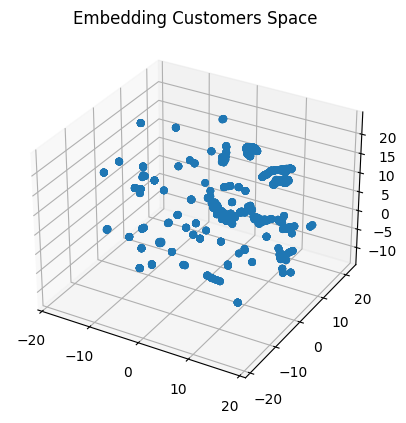

In [77]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embs[0], embs[1], embs[2]);
ax.set_title("Embedding Customers Space");

### 7.3. Vectorize New Space

In [78]:
df7 = spark.createDataFrame(embs_with_customer)

In [79]:
vec = VectorAssembler(
    inputCols=["0", "1", "2"],
    outputCol="features"
)

df71 = vec.transform(df7).select("features", "customerid")

## 8.0. Pre Clusters Analysis

In [80]:
df8 = df71.select("features", "customerid")

### 8.1. Check Silhouette Scores

In [81]:
cluster_list = range(4, 30)

#### 8.1.1. K-Means

In [170]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.KMeans.html#pyspark.ml.clustering.KMeans

k_mean_silhouettes = []

for k in cluster_list:
    print(f"Start Fitting for K: {k}")
    
    km = KMeans(
        featuresCol="features",
        maxIter=500,
        k=k,
    )

    km = km.fit(df8)

    km.setPredictionCol("cluster")

    df_clusters = km.transform(df8)

    ev = ClusteringEvaluator(metricName="silhouette")
    ev.setPredictionCol("cluster")

    k_mean_silhouettes.append(ev.evaluate(df_clusters))

Start Fitting for K: 4
Start Fitting for K: 5
Start Fitting for K: 6
Start Fitting for K: 7
Start Fitting for K: 8
Start Fitting for K: 9
Start Fitting for K: 10
Start Fitting for K: 11
Start Fitting for K: 12
Start Fitting for K: 13
Start Fitting for K: 14
Start Fitting for K: 15
Start Fitting for K: 16
Start Fitting for K: 17
Start Fitting for K: 18
Start Fitting for K: 19
Start Fitting for K: 20
Start Fitting for K: 21
Start Fitting for K: 22
Start Fitting for K: 23
Start Fitting for K: 24
Start Fitting for K: 25
Start Fitting for K: 26
Start Fitting for K: 27
Start Fitting for K: 28
Start Fitting for K: 29


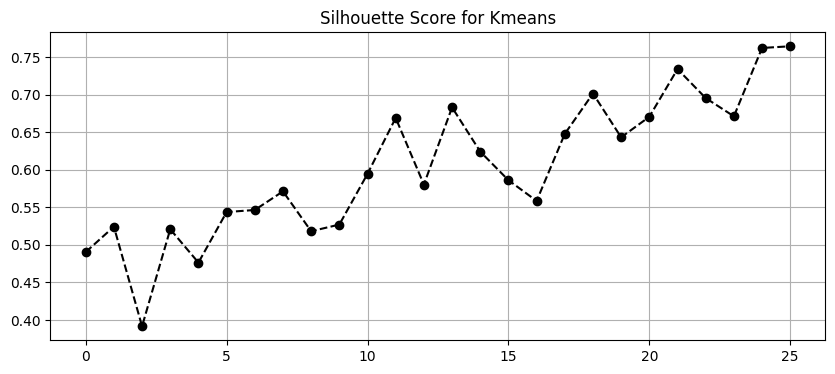

In [171]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(k_mean_silhouettes, "k--", marker="o")
ax.set_title("Silhouette Score for Kmeans")
ax.grid(2)

##### 8.1.2.2. KMeans Cluster Inspection

In [172]:
# df_clusters.select("cluster", "customerid").groupBy("cluster").agg(pf.count(pf.col("customerid")).alias("clusters")).show()

In [176]:
plot_clusters = embs_with_customer.copy()
plot_clusters["cluster"] = [k[0] for k in df_clusters.select("cluster").collect()]

In [179]:
plot_clusters["cluster"].unique()

array([26, 14, 16,  0,  6,  1, 22,  9,  3, 23, 11, 28, 10, 12,  5, 27, 24,
       18, 25, 17, 19,  7, 20,  4,  8, 13,  2, 21, 15])

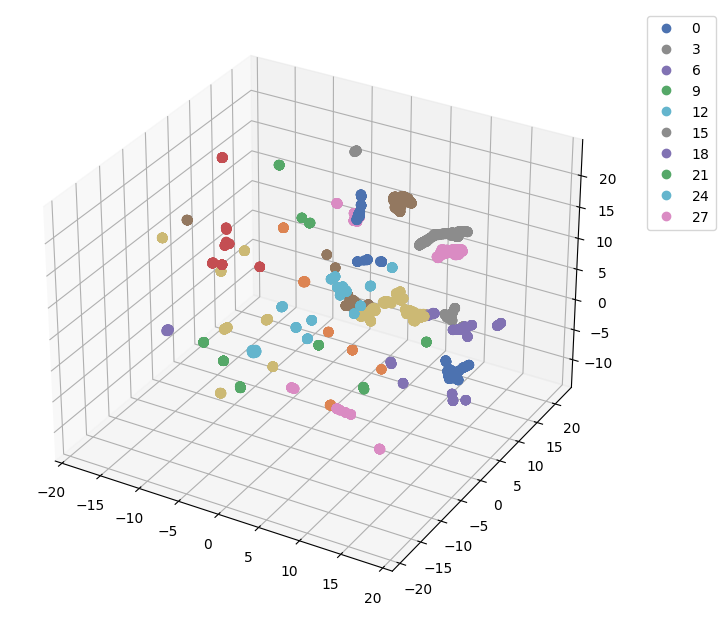

In [177]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
cmap = plt.matplotlib.colors.ListedColormap(sns.color_palette("deep", 256).as_hex())

sc = ax.scatter(
    plot_clusters[0], 
    plot_clusters[1],
    plot_clusters[2], 
    s=40, c=plot_clusters["cluster"], 
    marker='o', cmap=cmap, alpha=1
)

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2);

#### 8.1.2. GMM

In [164]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.GaussianMixture.html#pyspark.ml.clustering.GaussianMixture

gmm_silhouettes = []

for k in cluster_list:
    print(f"Start Fitting for K: {k}")

    gmm = GaussianMixture(
        featuresCol="features",
        maxIter=1000,
        k=k
    )

    gmm = gmm.fit(df8)

    gmm.setPredictionCol("cluster")

    df_clusters = gmm.transform(df8)

    ev = ClusteringEvaluator(metricName="silhouette")
    ev.setPredictionCol("cluster")

    gmm_silhouettes.append(ev.evaluate(df_clusters))

Start Fitting for K: 4
Start Fitting for K: 5
Start Fitting for K: 6
Start Fitting for K: 7
Start Fitting for K: 8
Start Fitting for K: 9
Start Fitting for K: 10
Start Fitting for K: 11
Start Fitting for K: 12
Start Fitting for K: 13
Start Fitting for K: 14
Start Fitting for K: 15
Start Fitting for K: 16
Start Fitting for K: 17
Start Fitting for K: 18
Start Fitting for K: 19
Start Fitting for K: 20
Start Fitting for K: 21
Start Fitting for K: 22
Start Fitting for K: 23
Start Fitting for K: 24
Start Fitting for K: 25
Start Fitting for K: 26
Start Fitting for K: 27
Start Fitting for K: 28
Start Fitting for K: 29


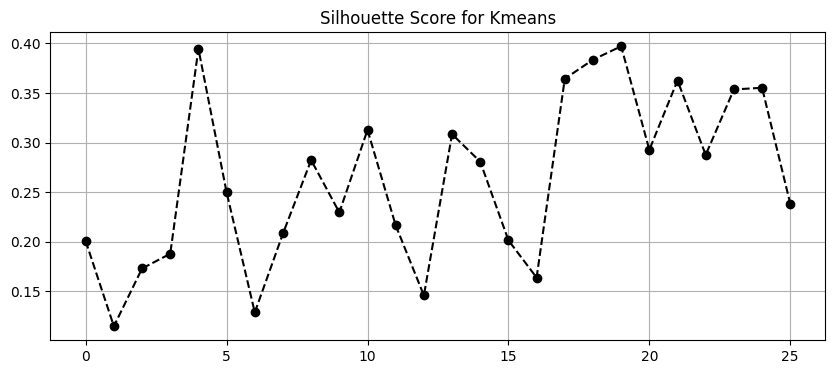

In [165]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(gmm_silhouettes, "k--", marker="o")
ax.set_title("Silhouette Score for Kmeans")
ax.grid(2)

##### 8.1.2.1. GMM Cluster Inspection

In [153]:
#gmm = GaussianMixture(
#    featuresCol="features",
#    maxIter=1000, # Converg
#    k=11
#)
#
#gmm = gmm.fit(df8)
#gmm.write().overwrite().save("../src/features/gmm_model.spark")

gmm = GaussianMixtureModel.load("../src/features/gmm_model.spark")
df_clusters = gmm.transform(df8)

ev = ClusteringEvaluator(metricName="silhouette")

print(f"Silhouette: {ev.evaluate(df_clusters)}")

Silhouette: 0.2364871829484324


In [108]:
#gaussian_means = np.array([k.mean.toArray() for k in gmm.gaussians])
#gaussian_covs = np.array([k.cov.toArray() for k in gmm.gaussians])

#plot_ellipsoids(gaussian_means, gaussian_covs)

In [183]:
plot_clusters = embs_with_customer.copy()
plot_clusters["cluster"] = [k[0] for k in df_clusters.select("prediction").collect()]

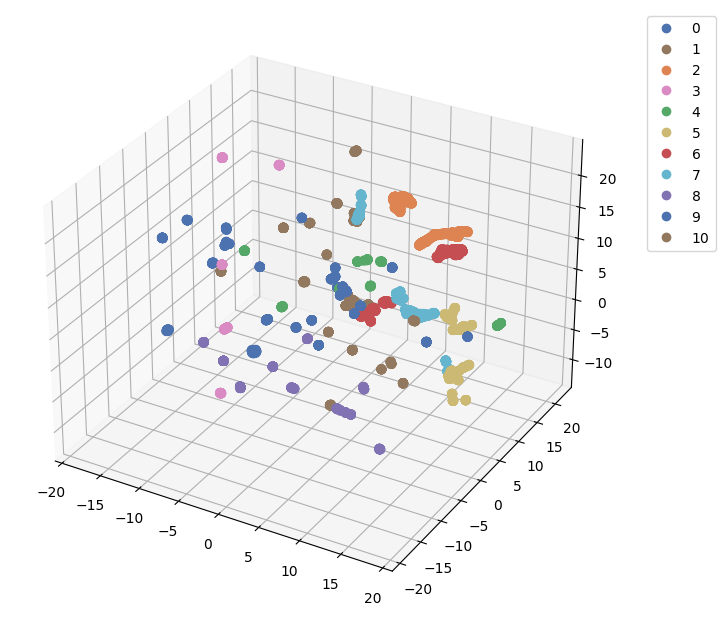

In [181]:
plot_clusters_3d(plot_clusters)

## 9.0. Machine Learning Models

In [82]:
df9 = df8.select(df8.columns)

In [83]:
df9.show(2)

+--------------------+----------+
|            features|customerid|
+--------------------+----------+
|[8.27910518646240...|     17420|
|[5.40200090408325...|     16503|
+--------------------+----------+
only showing top 2 rows



### 9.1. GMM Tuning

In [142]:
search_space = {
    "k": hp.quniform("k", 8, 12, 1), # Fixed Interval for good number of customers group 
    "tol": hp.quniform("tol", 0.0001, 0.1, 0.0001),
    "aggregationDepth": hp.quniform("aggregationDepth", 2, 10, 1),
}

max_evals = 50

In [143]:
#trials = SparkTrials(parallelism=4)
# df8_bc = sc.broadcast_data(df8)

best = fmin(
    fn=objective,
    algo=tpe.suggest,
    space=search_space,
    max_evals=max_evals,
    #trials=trials
)

100%|██████████| 50/50 [01:25<00:00,  1.70s/trial, best loss: -0.3565385705009156] 


In [146]:
best

{'aggregationDepth': 5.0, 'k': 8.0, 'tol': 0.0954}

In [147]:
gmm_tuned = GaussianMixture(
    featuresCol="features",
    maxIter=1000,
    **best
)

gmm_tuned._paramMap

{Param(parent='GaussianMixture_7805213ba4ca', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='GaussianMixture_7805213ba4ca', name='maxIter', doc='max number of iterations (>= 0).'): 1000,
 Param(parent='GaussianMixture_7805213ba4ca', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 5,
 Param(parent='GaussianMixture_7805213ba4ca', name='k', doc='Number of independent Gaussians in the mixture model. Must be > 1.'): 8,
 Param(parent='GaussianMixture_7805213ba4ca', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0).'): 0.0954}

In [148]:
gmm_tuned = gmm_tuned.fit(df9)

gmm_tuned.setPredictionCol("cluster")

df_clusters_tuned = gmm_tuned.transform(df9)

ev = ClusteringEvaluator(metricName="silhouette")
ev.setPredictionCol("cluster")

print(f"Silhouette: {ev.evaluate(df_clusters_tuned)}")

Silhouette: 0.3565385705009156


In [163]:
gaussian_means = np.array([k.mean.toArray() for k in gmm_tuned.gaussians])
gaussian_covs = np.array([k.cov.toArray() for k in gmm_tuned.gaussians])

plot_ellipsoids(gaussian_means, gaussian_covs)

In [161]:
gmm_tuned.write().overwrite().save("../src/features/gmm_tuned.spark")

## 10.0. Clusters Analysis

In [149]:
df10 = df4.select(selected_features)

df10 = df10.join(df_clusters_tuned.select("customerid", "cluster"), on="customerid", how="left")

### 10.1. Cluster Profile

In [150]:
df = df10.select("customerid", "cluster").groupBy("cluster").agg(pf.count(pf.col("customerid")).alias("total_clients"))

df = df.withColumn(
    "prec_clients",
    pf.round(pf.col("total_clients") / df10.count() * 100, 2)
)

df2 = df10.groupBy("cluster").agg(
    pf.round(pf.avg(pf.col("gross_revenue")), 3).alias("avg_gross"),
    pf.round(pf.avg(pf.col("recency_days")), 3).alias("avg_recency_days"),
    pf.round(pf.avg(pf.col("qtde_total_items")), 3).alias("avg_qtde_itens"),
    pf.round(pf.avg(pf.col("qtde_invoices")), 3).alias("avg_qtde_invoices"),
    pf.round(pf.avg(pf.col("qtde_returns")), 3).alias("avg_qtde_returns")
)

df = df.join(df2, how="inner", on="cluster")

df = df.sort(pf.col("avg_gross").desc())

In [154]:
df.show()

+-------+-------------+------------+---------+----------------+--------------+-----------------+----------------+
|cluster|total_clients|prec_clients|avg_gross|avg_recency_days|avg_qtde_itens|avg_qtde_invoices|avg_qtde_returns|
+-------+-------------+------------+---------+----------------+--------------+-----------------+----------------+
|      2|          409|        9.46| 7255.406|          49.367|      4201.976|            9.152|         181.929|
|      3|         1218|       28.16| 3002.677|          48.859|       1787.64|            7.437|          15.819|
|      4|          802|       18.54| 1267.595|          78.522|       788.889|            3.187|            1.03|
|      1|          259|        5.99|   724.38|          73.988|       396.278|              3.0|             0.0|
|      0|          727|       16.81|  465.821|         105.437|       289.045|            1.322|             0.0|
|      7|          301|        6.96|  403.062|          95.947|        202.14|          

### 10.2. Visual Inspection

In [157]:
plot_clusters = embs_with_customer.copy()
plot_clusters["cluster"] = [k[0] for k in df_clusters_tuned.select("cluster").collect()]

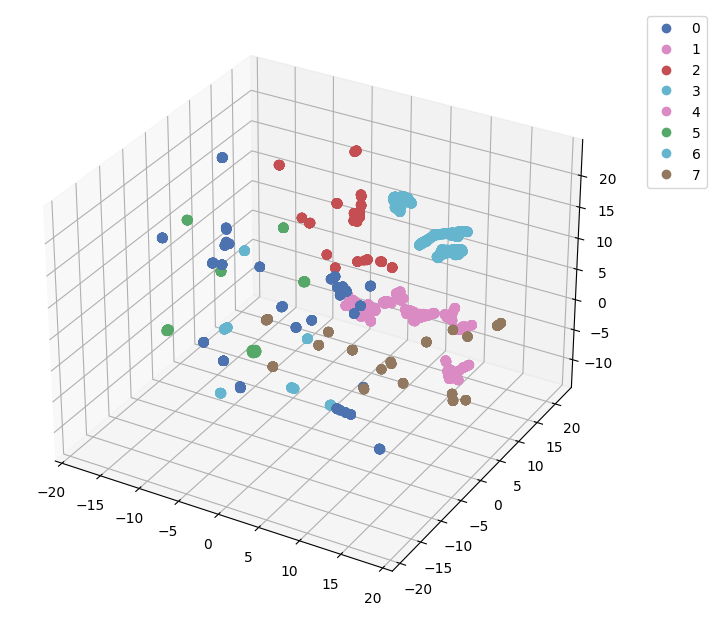

In [159]:
plot_clusters_3d(plot_clusters)